Presented by: Reza Saadatyar 2022-2023<br/>
E-mail: Reza.Saadatyar92@gmail.com<br/>
[Link](https://github.com/RezaSaadatyar/Deep-Learning-in-python)

**Recurrent Neurons and Layers**

![Alt text](1.jpg)
![Alt text](2.jpg)

================================== Importing the required Libraries ===========================

In [98]:
import os
import sys
import math 
import numpy as np
import pandas as pd
import yfinance as yf          # pip install yfinance
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

========================================= Functions ==================================

In [128]:
# =============================================== Preparing data =====================================================
def Prepare_data(data):  
     # -------------------------------------------- Step 1.1: Check type data ----------------------------------------     
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
        
    return data

# ============================================= Sequences data =======================================================
def sequences_data(data, x_steps=6, y_steps=3, train_size=0.7, nfeatures=1):
    # !============================================= Step 1: Split data ==============================================
    # -------------------------------------------- Step 1.1: Check type data -----------------------------------------    
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
    # ----------------------------------------------- Step 1.3: split ------------------------------------------------   
    n = math.floor(data.shape[0] * train_size)
    dat_train = data.iloc[0:n,:]
    data_train = dat_train.values.reshape(-1,1)
    
    dat_test = data.iloc[data_train.shape[0]-x_steps:,:]
    data_test = dat_test.values.reshape(-1,1)
    # !============================================== Step 2: Normalize ==============================================
    mod = MinMaxScaler(feature_range=(0, 1))
    # data_train = mod.fit_transform(data_train)
    # data_test = mod.transform(data_test.reshape(-1,1))
    # !============================================== Step 3: Sequences ==============================================
    # --------------------------------------------- Step 3.1: Sequences x_train --------------------------------------
    x_train = []
    y_train = []
    for i in range(x_steps, len(data_train)-y_steps+1):
        x_train.append(data_train[i-x_steps:i, 0])
        y_train.append(data_train[i:i+y_steps, 0])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], nfeatures))
    # -------------------------------------------- Step 3.2: Sequences x_test ----------------------------------------
    x_test = []
    y_test = []
    for i in range(x_steps, len(data.iloc[n:,:])+x_steps-y_steps+1):
        x_test.append(data_test[i-x_steps:i, 0])
        y_test.append(data_test[i:i+y_steps, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test, dat_train, dat_test, mod

# ============================================= Plot prediction ======================================================
def plot_prediction(data_train, data_test, pred_train, pred_test):
    
    _, axs = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(8, 3))
    # axs[0].plot(data.iloc[0:pred_train.shape[0],:], label='Train data')
    axs[0].plot(data_train, label='Train data')
    axs[0].plot(data_train.index[:pred_train.shape[0]], pred_train[:,0], label='Estimate')
    axs[0].legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)

    axs[1].plot(data_test, label='Test data')
    axs[1].plot(data_test.index[:pred_test.shape[0]:], pred_test[:,0], label='Estimate')
    axs[1].legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)

    axs[0].autoscale(enable=True, axis="x",tight=True)
    axs[1].autoscale(enable=True, axis="x",tight=True)
    plt.subplots_adjust(wspace=0.04, hspace=0.2)

*Step 1.1: Load Data*

In [100]:
data = sm.datasets.sunspots.load_pandas()  
data = data.data["SUNACTIVITY"]

In [101]:
data = Prepare_data(data)
print(f"{data = }")

data =      SUNACTIVITY
0            5.0
1           11.0
2           16.0
3           23.0
4           36.0
..           ...
304         40.4
305         29.8
306         15.2
307          7.5
308          2.9

[309 rows x 1 columns]


*Step 1.2: Plot data*

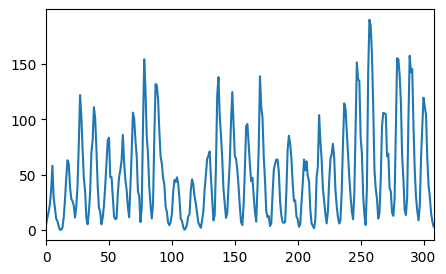

In [102]:
_, axs = plt.subplots(nrows=1,sharey='row', figsize=(5,3))
axs.plot(data)
axs.set_xlabel('', fontsize=10)
axs.set_title(f"", fontsize=10)
axs.set_ylabel('', fontsize=10)
axs.autoscale(enable=True, axis="x",tight=True)

*Step 2: Sequences*

In [112]:
x_steps = 6
y_steps = 2
x_train, y_train, x_test, y_test, data_train, data_test, mod = sequences_data(data, x_steps, y_steps, train_size=0.6, nfeatures=1)

*Step 3: Creating a Sequential model:*<br/>
[Sequential model](https://keras.io/guides/sequential_model/)<br/>
[Dense layer](https://keras.io/api/layers/core_layers/dense/)<br/>
[Activation functions](https://keras.io/api/layers/activations/)<br/>
[Flatten layer](https://keras.io/api/layers/reshaping_layers/flatten/)<br/>

*Step 3.1: Simple Recurrent Neural Networks ([RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN))-Model*<br/>
*inputs $\Rightarrow$ A 3D tensor, with shape [batch, timesteps, feature].*

In [113]:
simple_rnn_mod = Sequential([SimpleRNN(50, return_sequences=True),
                            SimpleRNN(50),
                            Dense(y_steps)])
simple_rnn_mod.layers                                 # Print the model parameters

*Step 3.2: [Model compile](https://keras.io/api/models/model_training_apis/)*<br/>
[Metrics](https://keras.io/api/metrics/regression_metrics/)<br/>

In [114]:
simple_rnn_mod.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"])  # Regression:mean_squared_error

*Step 3.3: Fit Model*<br/>
[Fit method](https://keras.io/api/models/model_training_apis/)

In [115]:
history_train = simple_rnn_mod.fit(x_train, y_train, epochs=100, validation_split=0.15)

Epoch 1/100
5/5 [==============================] - 4s 132ms/step - loss: 3173.1179 - mean_absolute_error: 43.7857 - val_loss: 3785.4919 - val_mean_absolute_error: 50.7666
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 3067.0269 - mean_absolute_error: 42.5991 - val_loss: 3672.2295 - val_mean_absolute_error: 49.6558
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 2981.8186 - mean_absolute_error: 41.6939 - val_loss: 3592.2002 - val_mean_absolute_error: 48.8833
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 2918.6221 - mean_absolute_error: 41.0012 - val_loss: 3521.9934 - val_mean_absolute_error: 48.1983
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 2861.1848 - mean_absolute_error: 40.3688 - val_loss: 3460.6506 - val_mean_absolute_error: 47.5790
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 2814.5464 - mean_absolute_error: 39.8389 - val_loss: 3411.3923 - val_mean_abs

*Step 3.4: prediction*

In [116]:
pred_train = simple_rnn_mod.predict(x_train)
pred_test = simple_rnn_mod.predict(x_test)

4/4 [==============================] - 0s 3ms/step


((178, 2), (123, 2))

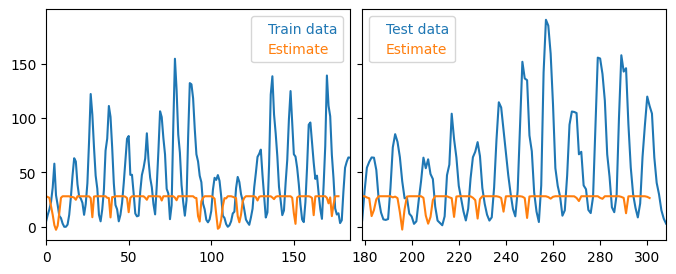

In [129]:
plot_prediction(data_train, data_test, pred_train, pred_test)